In [557]:
import random
import numpy
import csv
import pandas as pd

## Generating dataset

In [558]:
pulseList = [random.randrange(30,200) for i in range(100000)]

In [559]:
tempList = [round(numpy.random.uniform(36.0, 40.0),1) for i in range(100000)]

In [560]:
oxiList = [random.randrange(92,100) for i in range(100000)]

In [561]:
# statusList = ["" for i in range(2000)]
statusNumList = [0 for i in range(100000)]

In [562]:
measure = pd.DataFrame(list(zip(tempList, pulseList, oxiList, statusNumList)))
measure.columns =['BodyTemp','HeartRate','Oxi', 'HealthStatusCode']


In [563]:
measure

,BodyTemp,HeartRate,Oxi,HealthStatusCode
0,38.8,68,94,0
1,37.1,170,96,0
2,36.6,111,94,0
3,39.2,81,95,0
4,36.8,183,93,0
...,...,...,...,...
99995,37.7,174,92,0
99996,38.1,176,94,0
99997,37.9,83,95,0
99998,36.6,97,93,0


## Data labelling

In [564]:
for i in range (len(measure)):
    if (measure.loc[i,'BodyTemp']>38.0) | (measure.loc[i, 'HeartRate']<50) | (measure.loc[i, 'HeartRate']>100) | (measure.loc[i, 'Oxi']<95):
        # measure.loc[i, 'HealthStatus']="Unhealthy"
        measure.loc[i, 'HealthStatusCode']=1

    else: 
        # measure.loc[i, 'HealthStatus']="Healthy"
        measure.loc[i, 'HealthStatusCode']=0


In [565]:
measure

,BodyTemp,HeartRate,Oxi,HealthStatusCode
0,38.8,68,94,1
1,37.1,170,96,1
2,36.6,111,94,1
3,39.2,81,95,1
4,36.8,183,93,1
...,...,...,...,...
99995,37.7,174,92,1
99996,38.1,176,94,1
99997,37.9,83,95,0
99998,36.6,97,93,1


In [566]:
measure['HealthStatusCode'].values

array([1, 1, 1, ..., 0, 1, 1])

In [567]:
measure.to_csv('data.csv')

## Data Exploration

In [568]:
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [569]:
measure['HealthStatusCode'].unique()

array([1, 0])

In [570]:
measure['HealthStatusCode'].value_counts()

1    90528
0     9472
Name: HealthStatusCode, dtype: int64

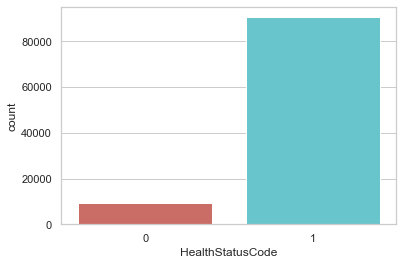

<Figure size 432x288 with 0 Axes>

In [571]:
sns.countplot(x='HealthStatusCode',data=measure,palette='hls')
plt.show()
plt.savefig('count_plot')

 Data is unbalanced

In [575]:
from sklearn.utils import resample
#create two different dataframe of majority and minority class 
df_majority = measure[(measure['HealthStatusCode']==1)] 
df_minority = measure[(measure['HealthStatusCode']==0)] 
# upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples= 90528, # to match majority class
                                 random_state=42)  # reproducible results
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_minority_upsampled, df_majority])

In [576]:
df_upsampled['HealthStatusCode'].value_counts()

0    90528
1    90528
Name: HealthStatusCode, dtype: int64

/Users/suparnasr/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='HealthStatusCode', ylabel='count'>

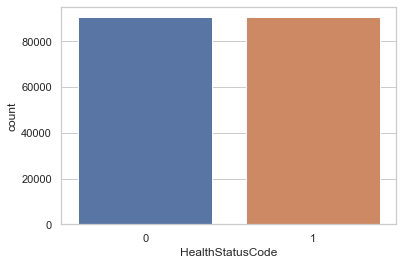

In [577]:
sns.countplot(df_upsampled['HealthStatusCode'])


In [578]:
df_upsampled.to_csv('upsampled_data.csv')

In [ ]:
# ct=pd.crosstab(measure['BodyTemp'],measure['HealthStatusCode']).plot(kind='bar')
# ct.plot(figsize=(20, 10))

# plt.title('Purchase Frequency for Job Title')
# plt.xlabel('Job')
# plt.ylabel('Frequency of Purchase')
# plt.savefig('purchase_fre_job')

## Training

In [579]:
X = df_upsampled[['BodyTemp', 'HeartRate','Oxi']]
y = df_upsampled.HealthStatusCode

In [580]:
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(126739, 3) (126739,)
(54317, 3) (54317,)


## Logistic Regression

In [581]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

In [582]:
pipe = make_pipeline(LogisticRegression(max_iter=1000))
param_grid = {'logisticregression__C': [0.001,0.01,0.1,1,10,100]}

LR = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, verbose=2)
LR.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(LR.best_score_))
print("Best parameters:\n{}".format(LR.best_params_))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best cross-validation score: 0.86
Best parameters:
{'logisticregression__C': 0.001}


In [583]:
y_pred = LR.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.8618664506508091


## Pickling

In [584]:
import pickle 
pickle.dump(LR,open('LR_model.pkl','wb'))

In [585]:
#Testing data
lr_test_accuracy_score= accuracy_score(y_test, LR.predict(X_test))
lr_test_precision_score= precision_score(y_test, LR.predict(X_test),average='weighted')
lr_test_recall_score= recall_score(y_test, LR.predict(X_test),average='weighted')
lr_test_f1_score= f1_score(y_test, LR.predict(X_test),average='weighted')

print("Accuracy: ",lr_test_accuracy_score)
print("Precision: ",lr_test_precision_score)
print("Recall: ",lr_test_recall_score)
print("F1 Score: ",lr_test_f1_score)

Accuracy:  0.8618664506508091
Precision:  0.8633561746152392
Recall:  0.8618664506508091
F1 Score:  0.8617058326970134


In [ ]:
#testing
conf = confusion_matrix(y_test, LR.predict(X_test))
fig, ax = plot_confusion_matrix(conf_mat=conf, figsize=(12, 12), cmap=plt.cm.Purples, colorbar=True)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

### Decision Tree Classifier

In [586]:

dt_pipe= Pipeline([('classifier', DecisionTreeClassifier())])
# Hyperparameters to tweak and find the optimum for GridSearchCV
maxDepth = [3,6,12,17,20]
minSamplesLeaf = [1,2,3,4,5]
minImpuritySplit = [0.001,0.003,0.006,0.008,0.01]
params = {
    'classifier__max_depth': maxDepth,
    'classifier__min_samples_leaf': minSamplesLeaf,
    'classifier__min_impurity_decrease': minImpuritySplit
}


# Initializing the GridSearchCV
dt_grid = GridSearchCV(dt_pipe, param_grid = params, cv=5, return_train_score=True, n_jobs = -1, verbose = 2)

# Fit the Grid Search to the provided data
dt_grid.fit(X_train, y_train)

print("Best cross-validation score: {:.2f}".format(dt_grid.best_score_))
print("Best parameters:\n{}".format(dt_grid.best_params_))

Fitting 5 folds for each of 125 candidates, totalling 625 fits
Best cross-validation score: 1.00
Best parameters:
{'classifier__max_depth': 6, 'classifier__min_impurity_decrease': 0.001, 'classifier__min_samples_leaf': 1}


In [587]:
dt_grid.best_score_

1.0

In [588]:
dt_grid.score(X_train, y_train)

1.0

In [589]:
dt_grid.score(X_test, y_test)

1.0

In [590]:
#testing
acc_dt_test = accuracy_score(y_test, dt_grid.predict(X_test))
pre_dt_test = precision_score(y_test, dt_grid.predict(X_test),average='weighted')
rec_dt_test = recall_score(y_test, dt_grid.predict(X_test),average='weighted')
f1_dt_test = f1_score(y_test, dt_grid.predict(X_test),average='weighted')
print(acc_dt_test)
print(pre_dt_test)
print(rec_dt_test)
print(f1_dt_test)

1.0
1.0
1.0
1.0


### Multinomial Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

pipe= make_pipeline(MultinomialNB())
param_grid = {'multinomialnb__alpha':[0.01,0.1,1]}
NB = GridSearchCV(pipe,param_grid,cv=5)
NB.fit(X_train, y_train)
print("Best cv score:{:.2f}".format(NB.best_score_))
print("Best parameters:\n{}".format(NB.best_params_))


In [ ]:
#Testing data
nb_test_accuracy = accuracy_score(y_test, dt_grid.predict(X_test))
nb_test_precision = precision_score(y_test, dt_grid.predict(X_test),average='weighted')
nb_test_recall = recall_score(y_test, dt_grid.predict(X_test),average='weighted')
nb_test_f1 = f1_score(y_test, dt_grid.predict(X_test),average='weighted')

print("Accuracy: ",nb_test_accuracy)
print("Precision: ",nb_test_precision)
print("Recall: ",nb_test_recall)
print("F1 Score: ",nb_test_f1)

# Testing

In [ ]:
def load_data_from_path(filepath):
    df = pd.read_csv(filepath)
    return df

In [ ]:
def load_health_data():
    input_path = "measure.csv"
    df = load_data_from_path(input_path)
    return df

In [ ]:
def split_train_test_data():
    df = load_health_data()
    X = df.drop(columns=["charges"])
    
    y = measure['HealthStatusCode']
    X_train, X_test, y_train, y_test = train_test_split(measure, y, test_size=0.3)

    save_train_test_data(X_train, y_train, X_test, y_test)
    return X_train, y_train, X_test, y_test

In [ ]:
def save_train_test_data(Xtrain: pd.DataFrame, Ytrain: pd.DataFrame, Xtest: pd.DataFrame, Ytest: pd.DataFrame):
    Xtrain.to_csv("data/model_training_data/training_data.csv", index=False)
    Ytrain.to_csv("data/model_training_data/training_data_result.csv", index=False)
    Xtest.to_csv("data/model_testing_data/testing_data.csv", index=False)
    Ytest.to_csv("data/model_testing_data/testing_data_result.csv", index=False)
    return

In [ ]:
def predict_on_test_data(model, xtest):
    y_test = model.predict(xtest)
    filename = str(model.__class__.__name__)+"predicted output.csv"
    prediction = pd.DataFrame(y_test)
    pd.DataFrame(y_test).to_csv("data/model_testing_data/"+filename)
    return prediction

In [ ]:
import pytest


@pytest.mark.parametrize("test_input,expected", [("3+5", 8), ("2+4", 6), ("6*9", 42)])
def test_eval(test_input, expected):
    assert eval(test_input) == expected

In [ ]:
test_eval("6",6)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
def DecisionTreeClassifier(xtrain, ytrain):
    DS = DecisionTreeClassifier()
    DS.fit(xtrain, ytrain)
    return DS

In [ ]:
@pytest.fixture
def Decision_Tree_prediction(data_preparation):
    xtrain, ytrain, xtest, ytest = data_preparation
    ds = DecisionTreeClassifier(xtrain, ytrain)
    ypred = predict_on_test_data(ds, xtest)
    return xtest, ypred

In [ ]:
import pytest_check as check

def test_data_leak(data_preparation):
    xtrain, ytrain, xtest, ytest = data_preparation
    concat_df = pd.concat([xtrain, xtest])
    concat_df.drop_duplicates(inplace=True)
    assert concat_df.shape[0] == xtrain.shape[0] + xtest.shape[0]
def test_predicted_output_shape(Decision_Tree_prediction):
    print("Decision_Tree_prediction")
    xtest, ypred = Decision_Tree_prediction
    check.equal(ypred.shape, (xtest.shape[0], ))
    # assert ypred.shape == (xtest.shape[0], 1)
    

In [ ]:
def test_healthy_unhealthy_invariance(return_models):
    models = return_models
    for model in models:
        print("Checking for " + str(model.__class__.__name__))
        sample_1 = [39.9,190,95,0]
        sample_2 = [19, 0, 27,0]
        result_healthy_sample = model.predict(np.array(sample_1).reshape(1, -1))
        result_unhealthy_sample = model.predict(np.array(sample_2).reshape(1, -1))
        check.equal(result_healthy_sample, result_unhealthy_sample)
        